In [40]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import pandas as pd
from scipy.integrate import quad
from functools import partial
from scipy.fftpack import fft, ifft
from scipy.interpolate import interp1d
from scipy import interpolate
import mpl_toolkits.mplot3d.axes3d as plt_3d
from Option_function import BSM 
import warnings
warnings.filterwarnings('ignore')
import scipy as scp
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
import matplotlib.gridspec as gridspec
%matplotlib inline

from scipy import sparse
from scipy.sparse.linalg import splu
from scipy.sparse.linalg import spsolve

# Heston Model

<font size=5 >*1.Introduction*</font>


I introduced lots of things based on Black-Scholes Model. The Black-Scholes Model is the cornerstone of modern option pricing theory. However, it really has lots of problems. For example, BS model suppose the volatility is constant which is not reasonable in the real world.

Therefore, there are many advanced models that relax the basic assumptions to perform modeling and analysis that are more specific to real-world scenarios. The Heston model is one of them.

The Heston Model factors in a possible correlation between a stock's price and its volatility.

It conveys volatility as reverting to the mean

It gives a closed-form solution, meaning that the answer is derived from an accepted set of mathematical operations.

It doesn't require that stock prices follow a lognormal probability distribution

<font size=5 >*2.Heston Process*</font>

The Heston process is described by the folloing SDE:
$$\begin{cases}{\rm d}S_t = r S_t{\rm d}t + \sqrt{V_t}S_t{\rm d}W_{1t}\\{\rm d}V_t = \kappa(\theta - V_t){\rm d}t + \sigma\sqrt{V_t}S{\rm d}W_{2t}\\{\rm d}W_{1t}{\rm d}W_{2t}=\rho{\rm d}t\end{cases}$$

where:  
$S_t$: asset price at time t  
$r$:risk-free interest rate-theoretical rate on an asset carrying no risk  
$\sqrt{V_t}$:volatility of the asset price  
$\sigma$:volatility of the $\sqrt{V_t}$  
$\theta$:long-term price variance  
$\kappa$:rate of reversion to $\theta$  
${\rm d}t$:indefinitely small positive time increment  
$W_{1t}$:Brownian motion of the asset price  
$W_{2t}$:Brownian motion of the asset's price variance

It is a mean reverting process related to the square-root process under the probability measure.

Just like the Black-Scholes Model, we also need to change the probability measure to a risk-neutral measure.

The Heston Model under the risk-neutral measure is:

$$\begin{cases}{\rm d}S_t = \mu S_t{\rm d}t + \sqrt{V_t}S_t{\rm d}W_{1t}^{*}\\{\rm d}V_t = \kappa^{*}(\theta^{*} - V_t){\rm d}t + \sigma\sqrt{V_t}S{\rm d}W_{2t}^{*}\\{\rm d}W_{1t}^{*}{\rm d}W_{2t}^{*}=\rho{\rm d}t\end{cases}$$
where$$ \kappa^{*} = \kappa + \lambda,\qquad\theta^{*}=\frac{\kappa\theta}{(\kappa+\lambda)}$$


Let's look at the paths of our asset under Heston Model.

Suppose $X_t = \log(S_t) \space\text{and} Y_t = \log(vt)$
$$\begin{cases}{\rm d}X_t = \biggl(\mu - \frac{1}{2}e^{Y_t}\biggr){\rm d}t + e^{\frac{Y_t}{2}}{\rm d}W_t^{1}
\\{\rm d}Y_t = e^{-Y_t}\biggl[\kappa(\theta - e^{Y_t}) - \frac{1}{2}\sigma^2\biggr]{\rm d}t + \sigma e^{\frac{-Y_t}{2}}{\rm d}W_t^{2}\end{cases}$$



In [172]:
N = 1000000             # time steps 
paths = 3               # number of paths
T = 1
T_vec, dt = np.linspace(0,T,N, retstep=True )
dt_sq = np.sqrt(dt)

S0 = 100          # spot price
X0 = np.log(S0)   # log price
v0 = 0.04         # spot variance
Y0 = np.log(v0)   # log-variance 

mu = 0.1                                           # drift
rho = -0.2                                         # correlation coefficient
kappa = 2                                          # mean reversion coefficient
theta = 0.04                                       # long-term variance
sigma = 0.3                                        # Vol of Vol - Volatility of instantaneous variance
std_asy = np.sqrt( theta * sigma**2 /(2*kappa) )   # asymptotic standard deviation for the CIR process
assert(2*kappa * theta > sigma**2)                 # Feller condition

# Generate random Brownian Motion
MU = np.array([0, 0])
COV = np.matrix([[1, rho], [rho, 1]])
W = ss.multivariate_normal.rvs( mean=MU, cov=COV, size=(paths,N-1) )
W_S = W[:,:,0]   # Stock Brownian motion:     W_1
W_v = W[:,:,1]   # Variance Brownian motion:  W_2

# Initialize vectors
Y = np.zeros((paths,N))
Y[:,0] = Y0
X = np.zeros((paths,N))
X[:,0] = X0
v = np.zeros(N)

# Generate paths
for t in range(0,N-1):
    v = np.exp(Y[:,t])    # variance 
    v_sq = np.sqrt(v)     # square root of variance 
    
    Y[:,t+1] = Y[:,t] + (1/v)*( kappa*(theta - v) - 0.5*sigma**2 )*dt + sigma * (1/v_sq) * dt_sq * W_v[:,t]   
    X[:,t+1] = X[:,t] + (mu - 0.5*v)*dt + v_sq * dt_sq * W_S[:,t]

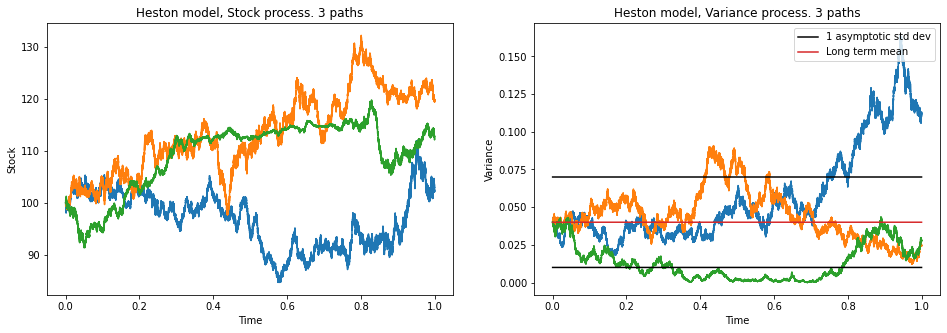

In [173]:
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

ax1.plot(T_vec, np.exp(X.T) )
ax1.set_title("Heston model, Stock process. 3 paths"); ax1.set_xlabel("Time"); ax1.set_ylabel("Stock")
ax2.plot(T_vec, np.exp(Y.T) )
ax2.set_title("Heston model, Variance process. 3 paths"); ax2.set_xlabel("Time"); ax2.set_ylabel("Variance")
ax2.plot(T_vec, (theta + std_asy)*np.ones_like(T_vec), label="1 asymptotic std dev", color="black" )
ax2.plot(T_vec, (theta - std_asy)*np.ones_like(T_vec), color="black" )
ax2.plot(T_vec, theta*np.ones_like(T_vec), label="Long term mean" )
ax2.legend(loc="upper right"); 
plt.show()

<font size=5 >*3.European Option Pricing*</font>

In order to price European options using the Heston model, we can still analysis it by using BS framework. 

According to the Ito's lemma, $U(S,v,t)$ must satisfy the PDE:
$$\frac{1}{2}vS^{2}\frac{\partial^2 U}{\partial S^2} + \rho\sigma vS\frac{\partial^2 U}{\partial S\partial v}+\frac{1}{2}v\sigma^{2}\frac{\partial^2 U}{\partial v^2} + rs\frac{\partial U}{\partial S} + \{\kappa[\theta - v(t)]-\lambda v\}\frac{{\rm d}U}{{\rm d}v} +\frac{{\rm d}U}{{\rm d}t} = rU$$

A European call option with a strike price K, maturing at time T is subject to the following conditions:
$$U(S,v,t)= \max(S-k,0)$$
$$U(0,v,t)=0$$
$$U(S,\infty,t)=S$$
$$\frac{{\rm d}U}{{\rm d}S}(\infty , v,t)=1$$
$$rs\frac{{\rm d}U}{{\rm d}S}(S,0,t)+\kappa\theta\frac{{\rm d}U}{{\rm d}v}(S,0,t)-rU(S,0,t)+U_t(S,0,t)=0$$

Therefore, our Heston Pricing formual for a call option is:

$$C(S,v,t) = S_tP_1 - e^{-rt}KP_2$$

In the Black-Scholes Model, we use $N_1$ and $N_2$, and now, we replace them with $P_1$ and $P_2$.
$$P_j =\biggl[\frac{1}{2} + \frac{1}{\pi}\int_{0}^{\infty}Re\biggl[\frac{e^{-is\ln k}f_j(s,v,x)}{is}\biggr]{\rm d}s\biggr] $$

with all complex elements:
$$Re:\text{Real part of the number}$$
$$i:\text{complex number}$$
$$f_j(s,v,x)=exp(C_j(\tau,s)+D_j(\tau,s)v+isx)$$
$$C_j(\tau,s)=r i s \tau + \frac{a}{\sigma^2}\biggl[(RBS)\tau - 2\ln\biggl(\frac{1-g_je^{d_j\tau}}{1-g_j}\biggr)\biggr]$$
$$D_j = \frac{BRS}{\sigma^2}\biggl(\frac{1-e^{d_j\tau}}{1-g_je^{d_j\tau}}\biggr)$$
$$BRS=b_j - \rho\sigma i s+d_j$$
$$d_j = \sqrt{(\rho\sigma is)^2-\sigma^2(2u_jis - s^2)}$$
$$g_j = \frac{bj - \rho\sigma i s + d_j}{bj - \rho\sigma i s - d_j}$$
$$u_1 = 0.5, u_2 = 0.5, b_1 = \kappa -\rho\sigma, b_2 = \kappa$$

## Full code

In [150]:
class Heston_model:
    def __init__(self,cp, S0, K, T, q,r,params):
        '''
        :param cp:
        :param S0:
        :param K:
        :param T:
        :param q:
        :param r:
        :param params: contains[vol,v0,kappa,rho,theta]
        '''
        self.cp=cp
        self.S0=np.log(S0)
        self.K=np.log(K)
        self.T=T
        self.q=q
        self.params=params
        self.vol=self.params[0]
        self.r=r
        self.v0=self.params[1]
        self.kappa=self.params[2]
        self.rho=self.params[3]
        self.theta=self.params[4]
        self.i=1j
    
    def phi(self, u):        
        lamb = np.sqrt(self.vol**2 * (u**2 + u*self.i) + (self.kappa - self.rho*self.vol*u*self.i)**2)
        numerator = np.exp(u*self.i * self.S0 + u*(self.r-self.q)*self.T*self.i + (self.kappa*self.theta*self.T*(self.kappa-self.rho*self.vol*u*self.i))/self.vol**2)
        denominator = (np.cosh(lamb*self.T/2) + (self.kappa-self.rho*self.vol*u*self.i)/lamb * np.sinh(lamb*self.T/2)) ** (2*self.kappa*self.theta/self.vol**2)
        omega_u = numerator / denominator
        phi_u = omega_u * np.exp(- (u**2+u*self.i)*self.v0 / (lamb/np.tanh(lamb*self.T/2) + self.kappa - self.rho*self.vol*u*self.i))
        return phi_u
    def fHeston(self,s):
        # To be used a lot
        i=complex(0,1)
        prod = self.rho * self.vol * i * s
        # Calculate d
        d1 = (prod - self.kappa)**2
        d2 = (self.vol**2) * (i * s + s**2)
        d = np.sqrt(d1 + d2)
        # Calculate g
        g1 = self.kappa - prod - d
        g2 = self.kappa - prod + d
        g = g1 / g2
        # Calculate first exponential
        exp1 = np.exp(self.S0 * i * s) * np.exp(i * s * self.r * self.T)
        exp2 = 1 - g * np.exp(-d * self.T)
        exp3 = 1 - g
        mainExp1 = exp1 * np.power(exp2 / exp3, -2 * self.theta * self.kappa/(self.vol**2))
        # Calculate second exponential
        exp4 = self.theta * self.kappa * self.T / (self.vol**2)
        exp5 = self.v0 / (self.vol**2)
        exp6 = (1 - np.exp(-d * self.T)) / (1 - g * np.exp(-d * self.T))
        mainExp2 = np.exp((exp4 * g1) + (exp5 * g1 * exp6))
        return (mainExp1 * mainExp2)
    def closed_form(self):
        i=complex(0,1)
        P, iterations, maxNumber = 0, 1000, 100
        ds = maxNumber / iterations
        element1 = 0.5 * (np.exp(self.S0) - np.exp(self.K) * np.exp(-self.r * self.T))
        
        
        
        for j in range(1, iterations):
            s1 = ds * (2 * j + 1) / 2
            s2 = s1 - i
            numerator1 = self.fHeston(s2)
            numerator2 = np.exp(self.K) * self.fHeston(s1)
            denominator = np.exp(self.K * i * s1) * i * s1
            P += ds * (numerator1 - numerator2) / denominator
        element2 = P / np.pi
        return np.real((element1 + element2))
    
    def Heston_FFT(self):
        B=500
        N=2**10
        alpha=1.5
        k = self.K
        d_v = 500 / 2**10
        d_k = 2*np.pi / 500
        beta = self.S0 -  d_k * 2**10 / 2
        delta = np.zeros(2**10)
        delta[0] = 1
        
        v_vec = np.array([i * d_v for i in range(N)])
        k_vec = beta + np.linspace(0,N,N+1)[:-1] * d_k
        
        x = ((2-delta) * d_v * np.exp(-self.r*self.T)) / (2*(alpha+v_vec*1j)*(alpha+v_vec*1j+1)) * np.exp(-beta*v_vec*1j) * self.phi(v_vec-(alpha+1)*1j)
        y = fft(x)
        y_real = y.real
        C_T = np.exp(-alpha*(self.S0-d_k*(N/2-np.arange(0,N)))) / np.pi * y_real
        lst = interpolate.splrep(k_vec, C_T)
        c_price = interpolate.splev(k, lst)
        p_price=np.exp(self.K)*np.exp(-self.r*self.T)+c_price-np.exp(self.S0)
        if self.cp=='call':
            return c_price
        elif self.cp=='put':
            return p_price
        else:
            return 'Option Type Error'
    def simulate_Heston(self):
        np.random.seed(100)
        dt=1/252
        steps=int(self.T*252)
        size=(10000,steps+1)
        prices=np.zeros(size)
        sigs=np.zeros(size)
        S_t=np.exp(self.S0)
        v_t=self.v0
        prices[:, 0] = S_t
        sigs[:, 0] = v_t
        for i in range(steps):
            WT = np.random.multivariate_normal(np.array([0, 0]),cov=np.array([[1, self.rho],[self.rho, 1]]),size=10000) * np.sqrt(dt)
            S_t = S_t * (np.exp((self.r - 0.5 * v_t) * dt + np.sqrt(v_t) * WT[:, 0]))
            v_t = np.abs(v_t + self.kappa * (self.theta - v_t) * dt + self.vol * np.sqrt(v_t) * WT[:, 1])
            prices[:, i+1] = S_t
            sigs[:, i+1] = v_t
        data = pd.DataFrame(prices)
        final_price = data.iloc[:, -1]
        payoff = []
        if self.cp=='call':
            for i in list(final_price):
                payoff.append(np.maximum(i - np.exp(self.K), 0))
            Opt_value=np.mean(payoff)* np.exp(-self.r * self.T)
        elif self.cp=='put':
            for i in list(final_price):
                payoff.append(np.maximum(np.exp(self.K) - i, 0))
            Opt_value=np.mean(payoff)  * np.exp(-self.r * self.T)
        else:
            return 'Option Type Error'
        return data,sigs,Opt_value
    def simu_plot(self,type):
        if type=='price':
            plt.figure(figsize=(10,7))
            plt.plot(Heston_model(self.cp,self.S0,self.K,self.T,self.q,self.r,self.params).simulate_Heston()[0].T)
            plt.title('The simulation of Price via Heston Model',fontsize=18)
            plt.xlabel('Time steps')
            plt.ylabel('stock price')
        if type=='vol':
            plt.figure(figsize=(10,7))
            plt.plot(Heston_model(self.cp,self.S0,self.K,self.T,self.q,self.r,self.params).simulate_Heston()[1].T)
            plt.title('The simulation of vol via Heston Model',fontsize=18)
            plt.xlabel('Time steps')
            plt.ylabel('Volatility')

In [168]:
a=Heston_model('call',100,100,1,0,.05,[0.25,0.08,3,-0.8,0.1])
#cp, S0, K, T, q,r,[vol,v0,kappa,rho,theta]

In [169]:
a.closed_form()

14.70340714155153

In [170]:
a.simulate_Heston()[2]

14.249836211556492

In [171]:
a.Heston_FFT()

array(14.39741953)

<font size=5 >*4.Calibration*</font>

In the previous section, I introduced the formula and code about Pricing Option under Heston Model given all the hyperparameters are known.

In fact, all of hyperparameter,such as $\kappa,\rho,\theta$, will always be changed and we don't know in advance. Therefore, there is a process that is not involved in the Blakc-Scholes model, but must be carried out in Heston model, that is, calibration. 

What we do is use the vanilla options being traded to calibrate a set of parameter of the Heston model and use these parameters we get from market to calculate the price of Option via different methods we want.

In the next section, I will use the real data to calibrate the parameter under the Heston model and show you the full code of this process. 
